In [1]:
!pip install pandas numpy scikit-learn imbalanced-learn xgboost joblib matplotlib seaborn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib


In [4]:
# Load dataset
df = pd.read_csv("/content/TESS.csv")

# Remove unwanted classes (APC and FA)
df = df[~df["tfopwg_disp"].isin(["APC", "FA"])]

# Display remaining classes
print("Remaining classes:", df["tfopwg_disp"].unique())
print("Shape after removing unwanted:", df.shape)

# Handle missing values by imputing with mean
df = df.fillna(df.mean(numeric_only=True))


Remaining classes: ['FP' 'PC' 'KP' 'CP']
Shape after removing unwanted: (7143, 12)


In [5]:
# Derived features (can help model learn ratios)
df["radius_to_star"] = df["pl_rade"] / df["st_rad"]
df["temp_ratio"] = df["pl_eqt"] / df["st_teff"]
df["scaled_flux"] = df["pl_insol"] / (df["st_dist"] ** 2)

# Replace infinite values (from division by zero) with NaN, then fill again
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(df.mean(numeric_only=True))


In [6]:
# Derived features (can help model learn ratios)
df["radius_to_star"] = df["pl_rade"] / df["st_rad"]
df["temp_ratio"] = df["pl_eqt"] / df["st_teff"]
df["scaled_flux"] = df["pl_insol"] / (df["st_dist"] ** 2)

# Replace infinite values (from division by zero) with NaN, then fill again
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(df.mean(numeric_only=True))


In [7]:
# Encode target
le = LabelEncoder()
df["tfopwg_disp"] = le.fit_transform(df["tfopwg_disp"])

# Separate features and target
X = df.drop("tfopwg_disp", axis=1)
y = df["tfopwg_disp"]

print("Feature columns:", list(X.columns))
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Feature columns: ['pl_tranmid', 'pl_orbper', 'pl_trandurh', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad', 'radius_to_star', 'temp_ratio', 'scaled_flux']
Class mapping: {'CP': np.int64(0), 'FP': np.int64(1), 'KP': np.int64(2), 'PC': np.int64(3)}


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance classes with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

print("Before SMOTE:", y.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_res).value_counts().to_dict())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)


Before SMOTE: {3: 4679, 1: 1197, 0: 684, 2: 583}
After SMOTE: {1: 4679, 3: 4679, 2: 4679, 0: 4679}


In [9]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    class_weight="balanced_subsample"
)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
print("Random Forest Accuracy:", rf.score(X_test, y_test))
print(classification_report(y_test, rf_pred, target_names=le.classes_))


Random Forest Accuracy: 0.7692307692307693
              precision    recall  f1-score   support

          CP       0.78      0.84      0.81       936
          FP       0.82      0.78      0.80       936
          KP       0.78      0.83      0.80       936
          PC       0.70      0.62      0.66       936

    accuracy                           0.77      3744
   macro avg       0.77      0.77      0.77      3744
weighted avg       0.77      0.77      0.77      3744



In [10]:
xgb_params = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

grid = RandomizedSearchCV(
    xgb, xgb_params, n_iter=10, scoring='accuracy', cv=3,
    verbose=2, random_state=42, n_jobs=-1
)
grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_
xgb_pred = best_xgb.predict(X_test)

print("Best XGB params:", grid.best_params_)
print("XGBoost Accuracy:", best_xgb.score(X_test, y_test))
print(classification_report(y_test, xgb_pred, target_names=le.classes_))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:19:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB params: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
XGBoost Accuracy: 0.8918269230769231
              precision    recall  f1-score   support

          CP       0.90      0.95      0.92       936
          FP       0.89      0.89      0.89       936
          KP       0.92      0.96      0.94       936
          PC       0.86      0.76      0.81       936

    accuracy                           0.89      3744
   macro avg       0.89      0.89      0.89      3744
weighted avg       0.89      0.89      0.89      3744



In [11]:
voting = VotingClassifier(
    estimators=[('rf', rf), ('xgb', best_xgb)],
    voting='soft'
)
voting.fit(X_train, y_train)

v_pred = voting.predict(X_test)
print("Ensemble Accuracy:", voting.score(X_test, y_test))
print(classification_report(y_test, v_pred, target_names=le.classes_))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:19:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Accuracy: 0.8774038461538461
              precision    recall  f1-score   support

          CP       0.87      0.95      0.91       936
          FP       0.88      0.87      0.87       936
          KP       0.91      0.95      0.93       936
          PC       0.85      0.73      0.79       936

    accuracy                           0.88      3744
   macro avg       0.88      0.88      0.88      3744
weighted avg       0.88      0.88      0.88      3744



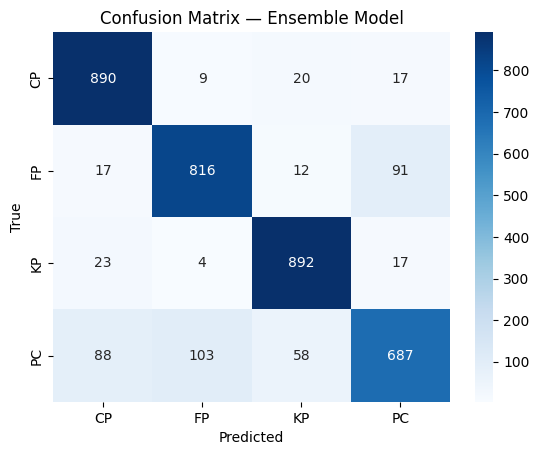

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, v_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix — Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [13]:
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(best_xgb, "xgboost_model.pkl")
joblib.dump(voting, "ensemble_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

print("✅ All models and preprocessing objects saved!")


✅ All models and preprocessing objects saved!


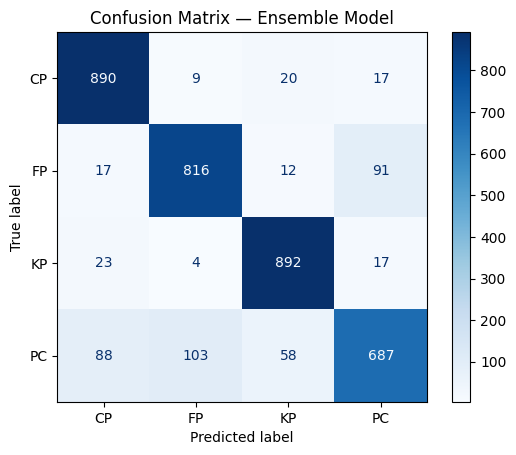

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(voting, X_test, y_test, display_labels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix — Ensemble Model")
plt.show()


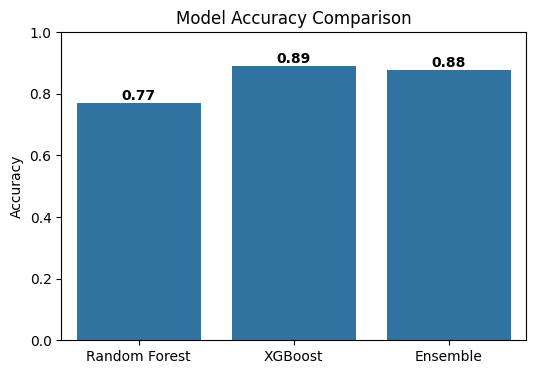

In [15]:
# Compare model accuracies
models = ['Random Forest', 'XGBoost', 'Ensemble']
accuracies = [
    rf.score(X_test, y_test),
    best_xgb.score(X_test, y_test),
    voting.score(X_test, y_test)
]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()


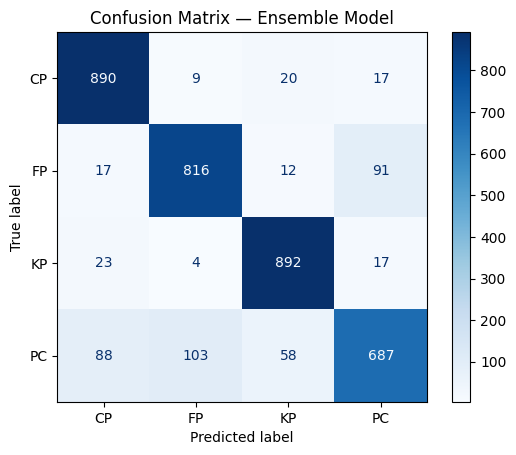

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(voting, X_test, y_test, display_labels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix — Ensemble Model")
plt.show()


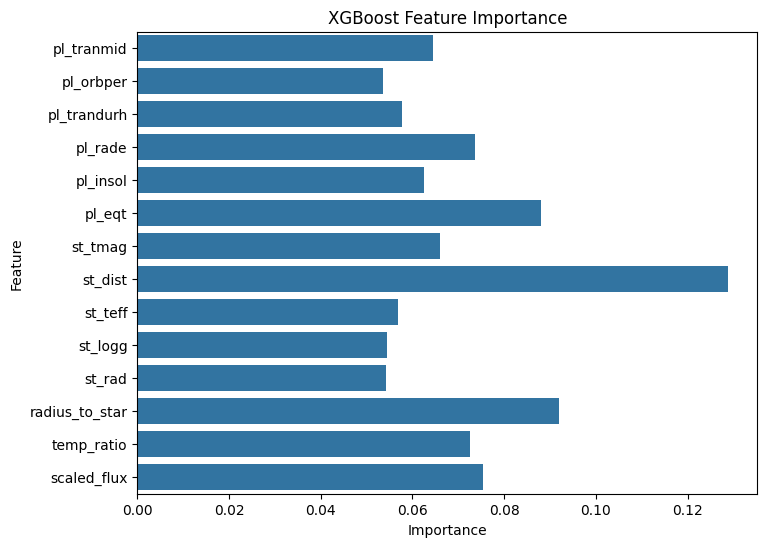

In [18]:
importances = best_xgb.feature_importances_
features = X.columns

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=features)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


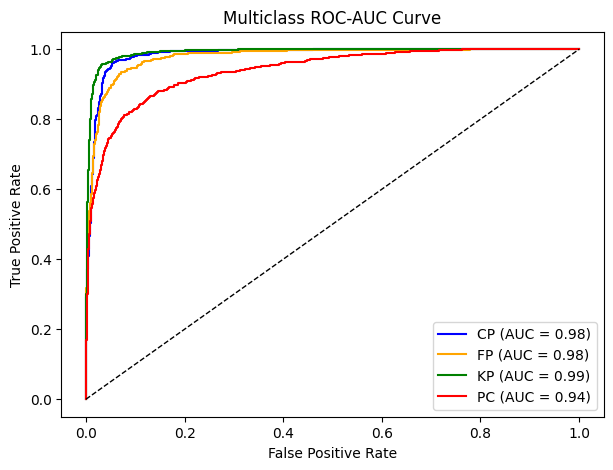

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = voting.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,5))
colors = cycle(['blue', 'orange', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC-AUC Curve')
plt.legend()
plt.show()
